In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import spacy 
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet as wn
from nltk.probability import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

nlp = spacy.load('en')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package stopwords to /Users/lina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/lina/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# 0. File reading and basic cleaning

In [7]:
#File read and organizing by number(rank)
df = pd.read_csv("https://raw.githubusercontent.com/adia4/Netflix_description/master/imbd.csv")
df["number"] = [re.sub(r'[.,]', '', period) for period in df["number"]]
df["number"] = [int(number) for number in df["number"]]
df = df.sort_values("number")

#keep only full series titles
df = df[-df.title.str.contains('^ ', regex= True, na=False)]

#remove titles that have "Add a Plot as a description"
df = df[-df.description.str.contains('Add a Plot', regex= True, na=False)]
#df["description"] = [re.sub(r'Add a Plot','Plotless',description) for description in df["description"]]

#clean "See full summary" from description
df["description"] = [re.sub(r'...See full summary\xa0','',description) for description in df["description"]]

#create a new range after removing non desired observations and map it into target column
a= range(0,len(df))
b = np.linspace(0,len(df),45,dtype='int')
df["number"] = a
assign = np.digitize(df["number"],b)
df["target"] = assign
df = df.reset_index()
df = df[["title","number","description","target"]]
imbd = df

In [8]:
df

,title,number,description,target
0,La casa de papel,0,An unusual group of robbers attempt to carry o...,1
1,Ozark,1,A financial advisor drags his family from Chic...,1
2,Community,2,A suspended lawyer is forced to enroll in a co...,1
3,Better Call Saul,3,The trials and tribulations of criminal lawyer...,1
4,The Walking Dead,4,Sheriff Deputy Rick Grimes wakes up from a com...,1
...,...,...,...,...
4457,Netflix - The Crown: Kneel Before Your Queen,4457,The real stars of The Crown.,44
4458,Father Soldier Son,4458,When Sgt. First Class Brian Eisch is criticall...,44
4459,Lenox Hill,4459,An intimate look at the lives of four doctors ...,44
4460,RuPaul's All Stars Drag Race,4460,RuPaul is back to preside over the fourth seas...,44


# 1. EDA

## 1.1 Wordcloud with the most common words

Most Common Words


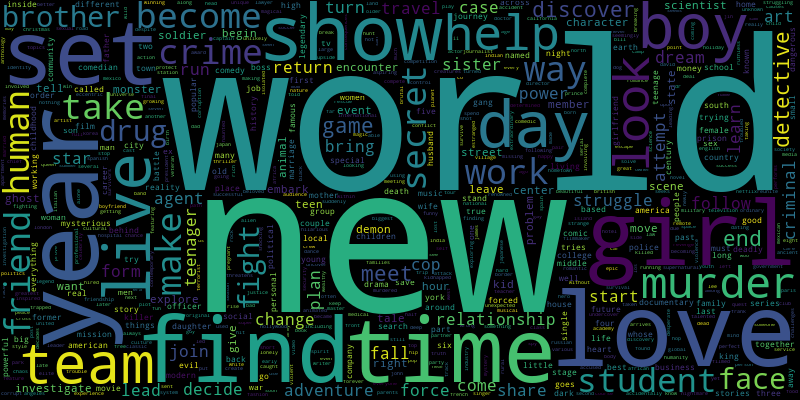

In [58]:
#making lower string, removing stopwords, tokenizing
imbd['description'] = imbd['description'].str.lower()
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')
imbd['tokenized'] = imbd['description'].apply(lambda row: tokenizer.tokenize(row))
#listing
listed= sum(imbd.tokenized,[])
filtered_list = [w for w in listed if not w in stop_words]
#frequency distribution
a=FreqDist(filtered_list)
d = pd.DataFrame({'Words': list(a.keys()),
                  'Count': list(a.values())})

print("Most Common Words")
d = d.nlargest(columns="Count", n = 1000) 
# Import the wordcloud library
#!pip install Wordcloud
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(d.Words))
# Create a WordCloud object
wordcloud = WordCloud(background_color="black", max_words=5000, contour_width=3, contour_color='steelblue',width=800, height=400)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [9]:
#1.1 Getting the description length and POS tag proportion for first 1500 obs
tweet_len=imbd.iloc[0:1500]['description'].str.split().map(lambda x: nltk.pos_tag(x))
a = []
noun = 0
adj = 0
vb = 0
others = 0
for i in range(0,len(tweet_len)):
    r = len(tweet_len[i])
    for j in range(0,r):
        if tweet_len[i][j][1] in ['NN','NNS','NNP','NNPS']: noun +=1
        elif tweet_len[i][j][1] in ['JJ','JJR','JJS']: adj +=1
        elif tweet_len[i][j][1] in ['VB','VBD','VBG','VBN','VBP','VBZ']: vb +=1
        else: others +=1
    a.append([noun/r,vb/r,adj/r,others/r])
    noun = 0
    adj = 0
    vb = 0
    others = 0

In [10]:
#1.2 Getting the description length and POS tag proportion for next 1500 obs

tweet_len0=imbd.iloc[1500:3000]['description'].str.split().map(lambda x: nltk.pos_tag(x))
b = []
noun = 0
adj = 0
vb = 0
others = 0
for i in range(1500,3000):
    s = len(tweet_len0[i])
    for j in range(0,s):
        if tweet_len0[i][j][1] in ['NN','NNS','NNP','NNPS']: noun +=1
        elif tweet_len0[i][j][1] in ['JJ','JJR','JJS']: adj +=1
        elif tweet_len0[i][j][1] in ['VB','VBD','VBG','VBN','VBP','VBZ']: vb +=1
        else: others +=1
    b.append([noun/s,vb/s,adj/s,others/s])
    noun = 0
    adj = 0
    vb = 0
    others = 0

In [11]:
#1.3 Getting the description length and POS tag proportion for last 1500 obs

tweet_len2=imbd.iloc[3000:4460]['description'].str.split().map(lambda x: nltk.pos_tag(x))
c = []
noun = 0
adj = 0
vb = 0
others = 0
for i in range(3000,4460):
    s = len(tweet_len2[i])
    for j in range(0,s):
        if tweet_len2[i][j][1] in ['NN','NNS','NNP','NNPS']: noun +=1
        elif tweet_len2[i][j][1] in ['JJ','JJR','JJS']: adj +=1
        elif tweet_len2[i][j][1] in ['VB','VBD','VBG','VBN','VBP','VBZ']: vb +=1
        else: others +=1
    c.append([noun/s,vb/s,adj/s,others/s])
    noun = 0
    adj = 0
    vb = 0
    others = 0

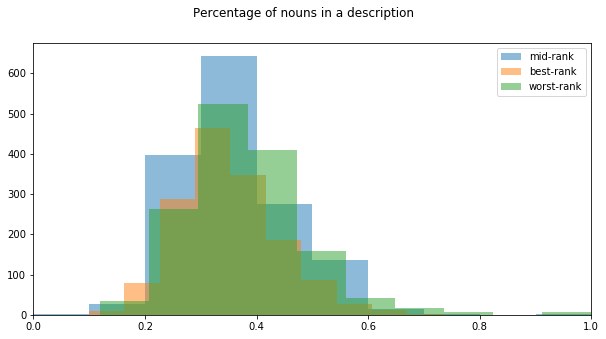

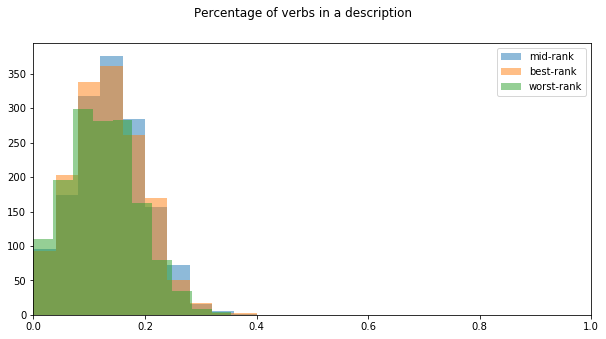

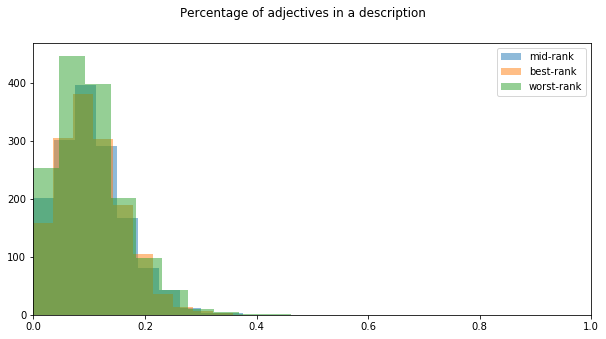

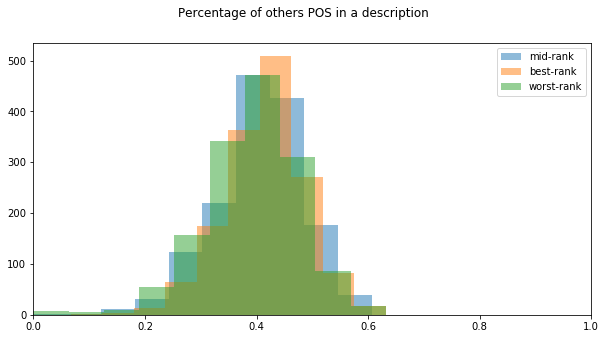

In [12]:
#plotting POS proportion 
fig,ax=plt.subplots(1,1,figsize=(10,5))
nouns2 = [c[i][0] for i in range(0,len(c))]
nouns1 = [a[i][0] for i in range(0,len(a))]
nouns0 = [b[i][0] for i in range(0,len(b))]
ax.hist(nouns0,label = 'mid-rank',alpha = 0.5)
ax.hist(nouns1,label = 'best-rank',alpha = 0.5)
ax.hist(nouns2,label = 'worst-rank',alpha = 0.5)
ax.legend(loc='upper right')
plt.xlim(xmin=0, xmax = 1)
fig.suptitle('Percentage of nouns in a description')

fig1,ax1=plt.subplots(1,1,figsize=(10,5))
nouns2 = [c[i][1] for i in range(0,len(c))]
nouns1 = [a[i][1] for i in range(0,len(a))]
nouns0 = [b[i][1] for i in range(0,len(b))]
ax1.hist(nouns0,label = 'mid-rank',alpha = 0.5)
ax1.hist(nouns1,label = 'best-rank',alpha = 0.5)
ax1.hist(nouns2,label = 'worst-rank',alpha = 0.5)
ax1.legend(loc='upper right')
plt.xlim(xmin=0, xmax = 1)
fig1.suptitle('Percentage of verbs in a description')

fig2,ax2=plt.subplots(1,1,figsize=(10,5))
nouns2 = [c[i][2] for i in range(0,len(c))]
nouns1 = [a[i][2] for i in range(0,len(a))]
nouns0 = [b[i][2] for i in range(0,len(b))]
ax2.hist(nouns0,label = 'mid-rank',alpha = 0.5)
ax2.hist(nouns1,label = 'best-rank',alpha = 0.5)
ax2.hist(nouns2,label = 'worst-rank',alpha = 0.5)
ax2.legend(loc='upper right')
plt.xlim(xmin=0, xmax = 1)
fig2.suptitle('Percentage of adjectives in a description')

fig3,ax3=plt.subplots(1,1,figsize=(10,5))
nouns2 = [c[i][3] for i in range(0,len(c))]
nouns1 = [a[i][3] for i in range(0,len(a))]
nouns0 = [b[i][3] for i in range(0,len(b))]
ax3.hist(nouns0,label = 'mid-rank',alpha = 0.5)
ax3.hist(nouns1,label = 'best-rank',alpha = 0.5)
ax3.hist(nouns2,label = 'worst-rank',alpha = 0.5)
ax3.legend(loc='upper right')
plt.xlim(xmin=0, xmax = 1)
fig3.suptitle('Percentage of others POS in a description')

plt.show()

In [13]:
# word_count
word_count = imbd['description'].apply(lambda x: len(str(x).split()))
# mean_word_length
mean_word_length = imbd['description'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# 2. Modelling

## 2.0 Baseline Model

In [14]:
########## CountVectorizer  ########## 
count_vectorizer = CountVectorizer(max_features=90,min_df=80,stop_words = stopwords.words('english'))
words = count_vectorizer.fit_transform(df.description)
new = pd.DataFrame(words.todense())
new.columns = count_vectorizer.get_feature_names()

########## Train - Validation with Linear Regression #####

X_train,X_test,y_train,y_test = train_test_split(new,df["target"],test_size=0.2,random_state = 1993)
#Train the model using the training sets
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm
#Predict Output
predictions = regressor.predict(X_test)
df_o = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
rmse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(r2)

0.04778711683088965


In [15]:
X = new
y = df["target"].values

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.549
Model:                            OLS   Adj. R-squared (uncentered):              0.541
Method:                 Least Squares   F-statistic:                              64.35
Date:                Sun, 03 May 2020   Prob (F-statistic):                        0.00
Time:                        20:56:18   Log-Likelihood:                         -19063.
No. Observations:                4462   AIC:                                  3.829e+04
Df Residuals:                    4379   BIC:                                  3.882e+04
Df Model:                          83                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
american        8.8344      1.648      5.362      0.000       5.604      12.065
around          3.3546      1.777      1.888      0.059      -0.129       6.839
back            4.7172      1.565      3.014      0.003       1.649       7.786
based           5.2416      1.859      2.820      0.005       1.597       8.886
become          4.8901      1.763      2.773      0.006       1.433       8.347
becomes         7.7329      1.656      4.671      0.000       4.487      10.979
behind          7.0635      2.006      3.521      0.000       3.130      10.997
best            7.3238      1.704      4.298      0.000       3.983      10.665
boy             3.4053      1.697      2.006      0.045       0.078       6.733
city            5.0287      1.508      3.334      0.001       2.071       7.986
comedian       15.8498      1.916      8.274      0.000      12.094      19.605
comedy          6.8872      1.392      4.946      0.000       4.157       9.617
crime           3.0608      1.835      1.668      0.095      -0.536       6.658
daughter        3.4318      1.711      2.006      0.045       0.078       6.786
day             5.1453      1.539      3.343      0.001       2.128       8.163
death           4.5752      1.749      2.616      0.009       1.146       8.004
documentary    15.6125      1.682      9.283      0.000      12.315      18.910
family          4.2003      0.951      4.415      0.000       2.335       6.065
father          5.0726      1.507      3.365      0.001       2.118       8.028
film           12.2468      1.386      8.834      0.000       9.529      14.965
find            6.4580      1.333      4.843      0.000       3.844       9.072
finds           6.9516      1.536      4.524      0.000       3.939       9.964
first           8.3403      1.629      5.120      0.000       5.147      11.534
follows         2.1893      1.722      1.272      0.204      -1.186       5.564
former          3.8265      1.868      2.048      0.041       0.164       7.489
four            4.6769      1.739      2.689      0.007       1.267       8.086
friend          2.1542      1.916      1.124      0.261      -1.602       5.910
friends         3.6341      1.215      2.990      0.003       1.251       6.017
get             8.3435      1.654      5.046      0.000       5.102      11.585
girl            2.5711      1.302      1.975      0.048       0.019       5.124
group           6.3244      1.317      4.801      0.000       3.742       8.907
help            7.4747      1.673      4.468      0.000       4.195      10.755
high            3.0247      1.626      1.860      0.063      -0.164       6.213
home            5.1804      1.541      3.362      0.001       2.160       8.201
journey         7.8958  

Even though our initial R-squared score (without validation) is not that low, the score after validation is. We are aware that it is a very challenging task to be able to predict the success or popularity of a title just based on the description it has. The variables could be so many more, like the actors included, the director, the title itself, the budget for marketing, etc.However our purpose is not to have a perfect model for the moment, but rather to be able to capture trends and insights around NLP features. Wouldn't it be much easier to change a few words on a description than to hire Tarantino as the director?


## 2.1 Lemmatization

In [16]:
#define function to get lemmas of each word
def get_lemmas(x):
    lemma_list= []
    x= nlp(x)
    for word in x:
        lemma_list.append(word.lemma_)
    return(lemma_list)

#apply lemmatization function
df["lemma_list"] = df["description"].apply(get_lemmas)

#paste words function
def paste_words(x):
    lower_words_nostopwords_pasted = []
    for word in x:
            lower_words_nostopwords_pasted.append(word) 
    return (' '.join(lower_words_nostopwords_pasted))

#paste lemmatized words
df["description_lemmas"] = df["lemma_list"].apply(paste_words)
df["description_lemmas"] = df["lemma_list"].apply(paste_words)

### 2.1.1 Lemmatization model

In [17]:
#Re-run model
count_vectorizer = CountVectorizer(max_features=90,min_df=50,stop_words = stopwords.words('english'))
words = count_vectorizer.fit_transform(df.description_lemmas)
new = pd.DataFrame(words.todense())
new.columns = count_vectorizer.get_feature_names()

########## Linear Regression #####
X = new
y = df["target"].values

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.605
Model:                            OLS   Adj. R-squared (uncentered):              0.597
Method:                 Least Squares   F-statistic:                              74.34
Date:                Sun, 03 May 2020   Prob (F-statistic):                        0.00
Time:                        20:57:21   Log-Likelihood:                         -18770.
No. Observations:                4462   AIC:                                  3.772e+04
Df Residuals:                    4372   BIC:                                  3.830e+04
Df Model:                          90                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
american        8.7092      1.545      5.636      0.000       5.680      11.739
around          2.3922      1.665      1.437      0.151      -0.872       5.657
back            1.9396      1.474      1.315      0.188      -0.951       4.830
base            4.2168      1.727      2.442      0.015       0.831       7.602
become          4.2040      1.017      4.134      0.000       2.210       6.198
boy             2.5979      1.449      1.792      0.073      -0.244       5.440
brother         0.7937      1.663      0.477      0.633      -2.467       4.054
child           4.2263      1.597      2.646      0.008       1.095       7.358
city            3.5743      1.322      2.704      0.007       0.983       6.166
come            3.3426      1.368      2.443      0.015       0.660       6.025
comedian       12.8431      1.680      7.645      0.000       9.550      16.137
comedy          6.1873      1.305      4.741      0.000       3.629       8.746
crime           2.2630      1.473      1.536      0.125      -0.625       5.151
daughter       -0.0695      1.541     -0.045      0.964      -3.091       2.952
day             3.4277      1.277      2.684      0.007       0.924       5.931
death           1.5830      1.582      1.000      0.317      -1.519       4.685
discover       -1.7268      1.436     -1.202      0.229      -4.542       1.089
documentary    14.6708      1.552      9.451      0.000      11.627      17.714
dream           2.1028      1.482      1.419      0.156      -0.802       5.007
face            5.1646      1.494      3.456      0.001       2.235       8.094
fall            0.9326      1.691      0.552      0.581      -2.382       4.247
family          2.0009      0.850      2.353      0.019       0.334       3.668
father          1.1847      1.419      0.835      0.404      -1.598       3.967
fight           2.9325      1.520      1.929      0.054      -0.048       5.913
film           11.2398      1.191      9.439      0.000       8.905      13.574
find            3.4544      0.885      3.901      0.000       1.718       5.190
first           5.3549      1.526      3.510      0.000       2.364       8.346
follow          3.3701      1.213      2.778      0.005       0.991       5.749
force           2.0071      1.355      1.482      0.138      -0.648       4.663
four            3.6753      1.631      2.253      0.024       0.477       6.874
friend          0.7954      0.981      0.811      0.418      -1.128       2.719
get             3.8594      1.052      3.669      0.000       1.797       5.922
girl            1.8804      1.084      1.735      0.083      -0.245       4.006
go              2.5350      1.150      2.204      0.028       0.280       4.790
good            5.1788  

## 2.2 POS Tagging

### 2.2.1 Extract POS Tags

In [18]:
df["words_list"] =[word.split() for word in df["description"]]

#To get the most common words let's start by creating a function that lowers all the words in our words list and apply
def to_lower(x):
    lower_words = []
    for word in x:
        word_lower = word.lower()
        lower_words.append(word_lower)
        
    return (lower_words)

#we will apply this function into our words list and create a new column
df["words_lower"] = df["words_list"].apply(to_lower)

nltk.download('averaged_perceptron_tagger')

#Function to get the Pos Tag for each word
def pos_tag(x):
  pos_tuple = []
  for word in x:
   pos_tuple=(nltk.pos_tag(x))
   pos_tag =[]
   for element in pos_tuple:
    pos_tag.append(element[1])   
  return(pos_tag)

#Function to get the Pos Tag element for each word
def pos_tag_element(x):
  pos_tuple = []
  for word in x:
   pos_tuple=(nltk.pos_tag(x))
   pos_tag =[]
   for element in pos_tuple:
    pos_tag.append(element[0])   
  return(pos_tag)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/lina/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [19]:
# Apply POS Tag function # APPROX TIME - 3 MINUTES
df["pos_tags"] = df["words_lower"].apply(pos_tag)
df["post_tags_pasted"] = df["pos_tags"].apply(paste_words)


In [20]:
#pasting pos tags with correspondent words
def zip_pos_tags(m,n):
    #new_tags= []   
    for tweet in m,n:
        new_tags = [m + "_" +str(n) for m,n in zip(m,n)]
        new_tags.append(new_tags)
    return new_tags[:-1]

#applying function to the word list and then pasting in a single column again
df['text_pos_tags'] = df.apply(lambda x: zip_pos_tags(x["words_lower"], x['pos_tags']), axis=1)

POS Tags Distribution


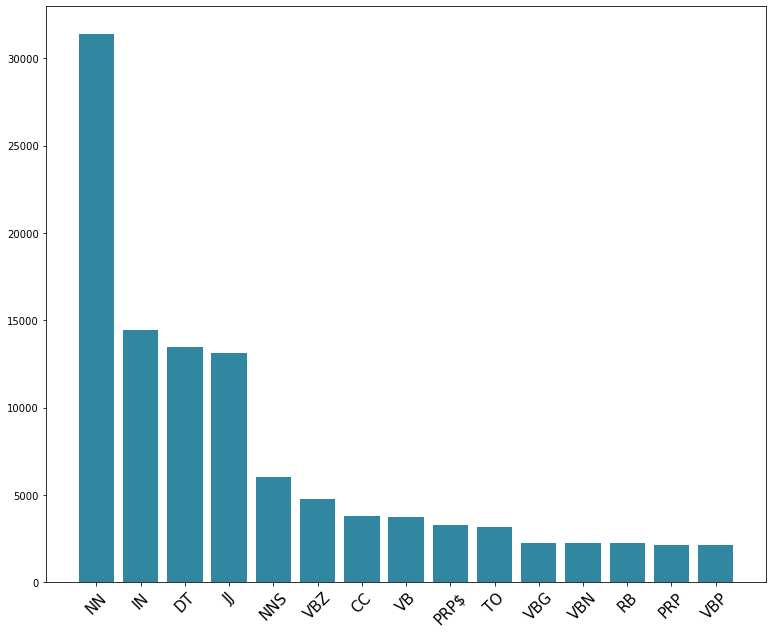

In [21]:
# Get the most common POS tags
pos_tags_stacked = np.hstack(df["pos_tags"])
pos_tags_stacked =pd.DataFrame(pos_tags_stacked)
pos_tags_stacked = pd.DataFrame(pos_tags_stacked[0].value_counts().head(15))
pos_tags_stacked = pos_tags_stacked.reset_index()

print("POS Tags Distribution")
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0,0,1,1])
ax.bar(pos_tags_stacked["index"],pos_tags_stacked[0], color="#3187a0")
plt.xticks(rotation=45, fontsize=15)
plt.show()

Most Common POS Tags


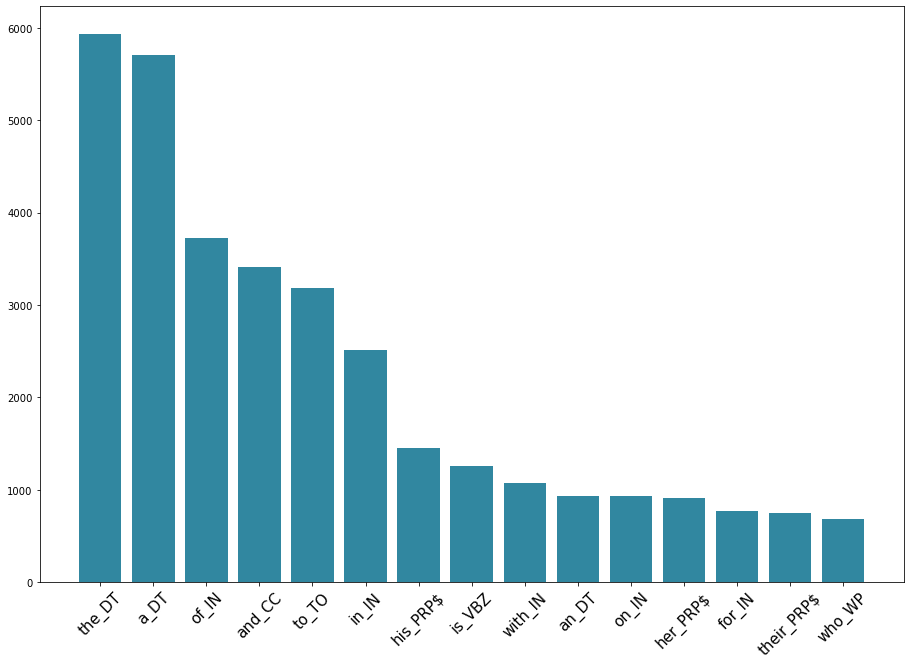

In [22]:
#most common words with their correspondant POS tags

pos_tags_labels_stacked =  np.hstack(df["text_pos_tags"])
pos_tags_labels_stacked =pd.DataFrame(pos_tags_labels_stacked)
pos_tags_labels_stacked =pd.DataFrame(pos_tags_labels_stacked[0].value_counts().head(15))
pos_tags_labels_stacked = pos_tags_labels_stacked.reset_index()

print("Most Common POS Tags")
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0,0,1,1])
ax.bar(pos_tags_labels_stacked["index"],pos_tags_labels_stacked[0], color="#3187a0")
plt.xticks(rotation=45, fontsize=15)
plt.show()

### 2.2.2 Get the count and proportion of POS Tags

In [23]:

df["words_count"] = df["words_list"].apply(len)

#Count the nouns 
def count_nouns(x):
    nouns = 0
    for word in x:
        if word == "NN":
         nouns += 1
    return(nouns
          )
df["nouns"] = df["pos_tags"].apply(count_nouns) #count of nouns
df["nouns_prop"] = df["nouns"]/df["words_count"] #proportion of nouns


#Count prepositions
def count_prepositions(x):
    prep = 0
    for word in x:
        if word == "IN":
         prep += 1
    return(prep)

df["prepositions"] = df["pos_tags"].apply(count_prepositions)
df["prepositions_prop"] = df["prepositions"]/df["words_count"]


#Count adjectives
def count_adj(x):
    adj = 0
    for word in x:
        if word == "JJ":
         adj += 1
    return(adj)

df["adjectives"] = df["pos_tags"].apply(count_adj)
df["adjectives_prop"] = df["adjectives"]/df["words_count"]

#Count determinants
def count_det(x):
    det = 0
    for word in x:
        if word == "DT":
         det += 1
    return(det)
df["determinants"] = df["pos_tags"].apply(count_det)
df["determinants_prop"] = df["determinants"]/df["words_count"]

#Count plural nouns
def count_noun_pl(x):
    nnp = 0
    for word in x:
        if word == "NNS":
         nnp += 1
    return(nnp)
df["plural_nouns"] = df["pos_tags"].apply(count_noun_pl)
df["plural_nouns_prop"] = df["plural_nouns"]/df["words_count"]


#Count vb 3rd person
def count_vbz(x):
    vbz = 0
    for word in x:
        if word == "VBZ":
         vbz += 1
    return(vbz)
df["verb_third"] = df["pos_tags"].apply(count_vbz)
df["verb_third_prop"] = df["verb_third"]/df["words_count"]


#Count verb base
def count_vb(x):
    vbz = 0
    for word in x:
        if word == "VB":
         vbz += 1
    return(vbz)
df["verb"] = df["pos_tags"].apply(count_vb)
df["verb_prop"] = df["verb"]/df["words_count"]


#Count Coordinated Conjuction
def count_cc(x):
    vbz = 0
    for word in x:
        if word == "CC":
         vbz += 1
    return(vbz)
df["cc"] = df["pos_tags"].apply(count_cc)
df["cc_prop"] = df["cc"]/df["words_count"]

#Count To
def count_to(x):
    vbz = 0
    for word in x:
        if word == "TO":
         vbz += 1
    return(vbz)
df["to"] = df["pos_tags"].apply(count_to)
df["to_prop"] = df["to"]/df["words_count"]

#Count Proper Nouns
def count_pnoun(x):
    vbz = 0
    for word in x:
        if word == "PRP$":
         vbz += 1
    return(vbz)
df["pnoun"] = df["pos_tags"].apply(count_pnoun)
df["pnoun_prop"] = df["pnoun"]/df["words_count"]

#Count Possesive Verbs
def count_pverbs(x):
    vbz = 0
    for word in x:
        if word == "VBN":
         vbz += 1
    return(vbz)
df["pverbs"] = df["pos_tags"].apply(count_pverbs)
df["pverbs_prop"] = df["pverbs"]/df["words_count"]

#Count Personal Pronouns
def count_ppnouns(x):
    vbz = 0
    for word in x:
        if word == "PRP":
         vbz += 1
    return(vbz)
df["ppnouns"] = df["pos_tags"].apply(count_ppnouns)
df["ppnouns_prop"] = df["ppnouns"]/df["words_count"]

#Count VMP
def count_vmp(x):
    vbz = 0
    for word in x:
        if word == "VMP":
         vbz += 1
    return(vbz)
df["vmp"] = df["pos_tags"].apply(count_vmp)
df["vmp_prop"] = df["vmp"]/df["words_count"]

#Count CD
def count_cd(x):
    vbz = 0
    for word in x:
        if word == "CD":
         vbz += 1
    return(vbz)
df["cd"] = df["pos_tags"].apply(count_cd)
df["cd_prop"] = df["cd"]/df["words_count"]

#Count VBD
def count_vbd(x):
    vbz = 0
    for word in x:
        if word == "VBD":
         vbz += 1
    return(vbz)
df["vbd"] = df["pos_tags"].apply(count_vbd)
df["vbd_prop"] = df["vbd"]/df["words_count"]

#Count WRB
def count_wrb(x):
    vbz = 0
    for word in x:
        if word == "WRB":
         vbz += 1
    return(vbz)
df["wrb"] = df["pos_tags"].apply(count_wrb)
df["wrb_prop"] = df["wrb"]/df["words_count"]

#Count WP
def count_wp(x):
    vbz = 0
    for word in x:
        if word == "WP":
         vbz += 1
    return(vbz)
df["wp"] = df["pos_tags"].apply(count_wp)
df["wp_prop"] = df["wp"]/df["words_count"]



In [24]:
#create new dataframe with only numeric columns

df_numeric = df[["nouns_prop","prepositions_prop","adjectives_prop","determinants_prop","plural_nouns_prop","verb_third_prop",\
                "ppnouns_prop","pverbs_prop","pnoun_prop","to_prop","cc_prop","verb_prop","vbd_prop","wrb_prop","wp_prop"]]

## 2.2.3 Model with POS Tags

### Each time we ran a model we optimized as much as we can playing with lemmas vs no lemmas version, max and min number of features, etc.

In [25]:
count_vectorizer = CountVectorizer(max_features=90,min_df=50,stop_words = stopwords.words('english'))
words = count_vectorizer.fit_transform(df.description) 
new = pd.DataFrame(words.todense())
new.columns = count_vectorizer.get_feature_names()
new = new.join(df_numeric) ########### Include numerical features as well. Will do from now on

########## Linear Regression #####

X = new
y = df["target"].values

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.782
Model:                            OLS   Adj. R-squared (uncentered):              0.777
Method:                 Least Squares   F-statistic:                              148.8
Date:                Sun, 03 May 2020   Prob (F-statistic):                        0.00
Time:                        21:00:52   Log-Likelihood:                         -17444.
No. Observations:                4462   AIC:                                  3.510e+04
Df Residuals:                    4357   BIC:                                  3.577e+04
Df Model:                         105                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
american              1.3019      1.164      1.119      0.263      -0.979       3.583
around               -0.2857      1.248     -0.229      0.819      -2.733       2.161
back                  0.8948      1.098      0.815      0.415      -1.259       3.048
based                -2.6293      1.342     -1.959      0.050      -5.260       0.002
become               -1.5524      1.244     -1.248      0.212      -3.992       0.887
becomes               0.0678      1.173      0.058      0.954      -2.232       2.367
behind                1.0312      1.407      0.733      0.464      -1.727       3.790
best                  2.6078      1.192      2.187      0.029       0.270       4.946
boy                  -1.0363      1.193     -0.869      0.385      -3.375       1.302
city                  0.2457      1.056      0.233      0.816      -1.825       2.317
comedian              5.9345      1.358      4.369      0.000       3.272       8.597
comedy                1.9806      0.977      2.026      0.043       0.064       3.897
crime                -4.4549      1.288     -3.458      0.001      -6.980      -1.929
daughter             -1.8064      1.202     -1.503      0.133      -4.163       0.550
day                   1.5027      1.078      1.394      0.163      -0.611       3.616
death                -0.4803      1.226     -0.392      0.695      -2.884       1.924
different            -1.9941      1.307     -1.526      0.127      -4.556       0.568
documentary           5.7684      1.185      4.867      0.000       3.445       8.092
family               -2.0196      0.674     -2.995      0.003      -3.342      -0.698
father               -1.1119      1.070     -1.039      0.299      -3.210       0.986
film                  5.5436      0.978      5.671      0.000       3.627       7.460
find                  0.0525      0.952      0.055      0.956      -1.814       1.919
finds                -0.9253      1.104     -0.838      0.402      -3.090       1.239
first                 3.4940      1.147      3.046      0.002       1.245       5.743
follows              -1.6087      1.213     -1.326      0.185      -3.987       0.770
former               -3.4009      1.315     -2.585      0.010      -5.980      -0.822
four                 -0.3993      1.223     -0.327      0.744      -2.797       1.998
friend               -0.6047      1.349     -0.448      0.654      -3.249       2.040
friends               0.1744      0.859      0.203      0.839      -1.510       1.859
get                   1.4968      1.175      1.274      0.203      -0.807       3.801
gets                  0.0164      1.297      0.013      0.990      -2.526       2.559
girl                 -0.1207      0.916     -0.132      0.89

POS tags were extremely challenging to work with. We tried using only the most popular, the least popular, the more o less popular, using them as an integer, binary variable and even proportion.They were not very easy to turn into actionable insights but as here and there we would find some potential recommendations (not in this particular case, however!) we will keep them in our further models. 

## 2.3 NER

In [26]:
# turn text into doc
df["doc"] =  df["description"].apply(nlp)

#get the entities 
def get_ner(doc):
 ner = doc.ents
 return(ner)

#apply function to doc
df["ner"] = df["doc"].apply(get_ner)

#get the labels of those entities we just greated
def get_ner_label(doc):
 label = []
 for i in doc:
        label.append(i.label_)
 return(label)

#apply the get label data to get our new column
df["ner_label"] = df["ner"].apply(get_ner_label)


In [27]:
#Putting NER into list to be able to get more common tags
df["ner_list"] = df["ner"].apply(list)
#pasting pos tags with correspondent words
def zip_pos_tags(m,n):
    #new_tags= []   
    for tweet in m,n:
        new_tags = [str(m) + "_" + str(n) for m,n in zip(m,n)]
        new_tags.append(new_tags)
    return new_tags[:-1]

#applying function to the word list and then pasting in a single column again
df['text_ner_tags'] = df.apply(lambda x: zip_pos_tags(x["ner_list"], x['ner_label']), axis=1)

Most Common NER Labels


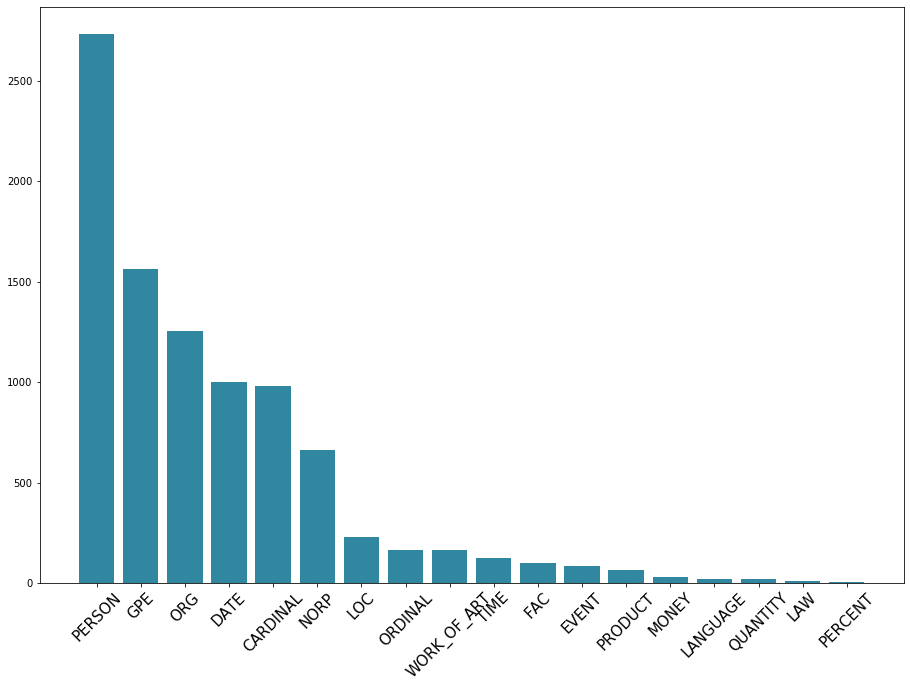

In [28]:
# Get most common NER Labels
ner_labels_stacked = np.hstack(df["ner_label"])
ner_labels_stacked= pd.DataFrame(ner_labels_stacked)
ner_labels_stacked = ner_labels_stacked[0].value_counts()
ner_labels_stacked = ner_labels_stacked.reset_index()

print("Most Common NER Labels")
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0,0,1,1])
ax.bar(ner_labels_stacked["index"],ner_labels_stacked[0], color="#3187a0")
plt.xticks(rotation=45, fontsize=15)
plt.show()

Most Common NER Labels


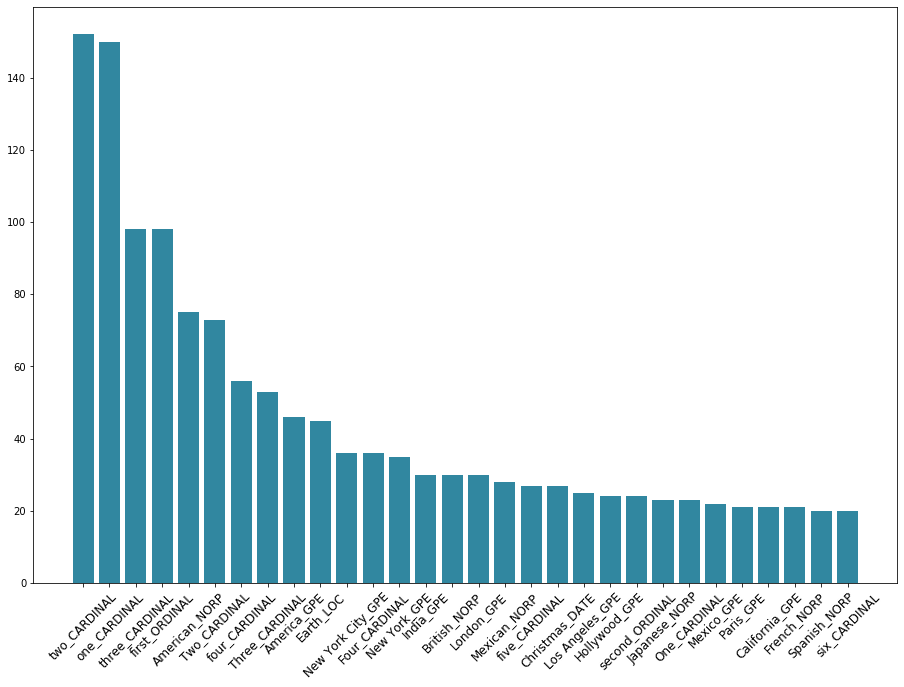

In [29]:
# Get most common NERs
ner_stacked = np.hstack(df['text_ner_tags'])
ner_stacked= pd.DataFrame(ner_stacked)
ner_stacked = ner_stacked[0].value_counts().head(30)
ner_stacked= ner_stacked.reset_index()

print("Most Common NER Labels")
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0,0,1,1])
ax.bar(ner_stacked["index"],ner_stacked[0], color="#3187a0")
plt.xticks(rotation=45, fontsize=12)
plt.show()

#### Even though the function is called count (it was our initial approach) it is a binary function that equals one if the description has at least one of the selected (top) NER tags

In [30]:
#Count the person
def count_person(x):
    person = 0
    for word in x:
        if word == "PERSON":
         person = 1
    return(person)
df["person"] = df["ner_label"].apply(count_person)

#Count the orgs
def count_orgs(x):
    person = 0
    for word in x:
        if word == "ORG":
         person = 1
    return(person)
df["orgs"] = df["ner_label"].apply(count_orgs)

#Count the gpe
def count_gpe(x):
    person = 0
    for word in x:
        if word == "GPE":
         person = 1
    return(person)
df["gpe"] = df["ner_label"].apply(count_gpe)

#Count the gpe
def count_norp(x):
    person = 0
    for word in x:
        if word == "NORP":
         person = 1
    return(person)
df["norp"] = df["ner_label"].apply(count_norp)

#Count the date
def count_date(x):
    person = 0
    for word in x:
        if word == "DATE":
         person = 1
    return(person)
df["date"] = df["ner_label"].apply(count_date)

#Count the loc
def count_loc(x):
    person = 0
    for word in x:
        if word == "LOC":
         person = 1
    return(person)
df["loc"] = df["ner_label"].apply(count_loc)

#Count the loc
def count_cardinal(x):
    person = 0
    for word in x:
        if word == "CARDINAL":
         person = 1
    return(person)
df["cardinal"] = df["ner_label"].apply(count_cardinal)

#Count the ordinal
def count_ordinal(x):
    person = 0
    for word in x:
        if word == "ORDINAL":
         person = 1
    return(person)
df["ordinal"] = df["ner_label"].apply(count_ordinal)

#Count the ordinal
def count_work_of_art(x):
    person = 0
    for word in x:
        if word == "WORK_OF_ART":
         person = 1
    return(person)
df["woa"] = df["ner_label"].apply(count_work_of_art)

In [31]:
## Include NER tags in our numeric matrix
df_numeric = df[["nouns_prop","prepositions_prop","adjectives_prop","determinants_prop","plural_nouns_prop",#POS
     "verb_third_prop", "ppnouns_prop","pverbs_prop","pnoun_prop","to_prop","cc_prop","verb_prop",#POS
     "vbd_prop","wrb_prop","wp_prop","pverbs_prop","pnoun_prop","verb_prop" #POS
                 ,"woa","ordinal","cardinal","loc","date","norp","gpe","orgs","person"]] # NER TAG
                

### Model Including NER tags

In [32]:
##### Run the model once again
count_vectorizer = CountVectorizer(max_features=90,min_df=50,stop_words = stopwords.words('english'))
words = count_vectorizer.fit_transform(df.description) #description lemmas instead of description
new = pd.DataFrame(words.todense())
new.columns = count_vectorizer.get_feature_names()
new = new.join(df_numeric)
########## Linear Regression #####

X = new
y = df["target"].values

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.783
Model:                            OLS   Adj. R-squared (uncentered):              0.777
Method:                 Least Squares   F-statistic:                              137.7
Date:                Sun, 03 May 2020   Prob (F-statistic):                        0.00
Time:                        21:01:44   Log-Likelihood:                         -17432.
No. Observations:                4462   AIC:                                  3.509e+04
Df Residuals:                    4348   BIC:                                  3.582e+04
Df Model:                         114                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
american              0.4937      1.236      0.400      0.690      -1.929       2.916
around               -0.3350      1.247     -0.269      0.788      -2.781       2.111
back                  0.9397      1.098      0.856      0.392      -1.214       3.093
based                -3.1180      1.346     -2.317      0.021      -5.756      -0.480
become               -1.6403      1.243     -1.319      0.187      -4.078       0.797
becomes               0.0796      1.172      0.068      0.946      -2.217       2.376
behind                0.9662      1.407      0.687      0.492      -1.792       3.724
best                  2.4861      1.192      2.086      0.037       0.149       4.823
boy                  -0.9314      1.192     -0.781      0.435      -3.269       1.406
city                  0.1152      1.060      0.109      0.913      -1.962       2.193
comedian              5.6936      1.360      4.187      0.000       3.028       8.360
comedy                1.7271      0.979      1.765      0.078      -0.191       3.646
crime                -4.4207      1.287     -3.435      0.001      -6.943      -1.898
daughter             -1.9177      1.201     -1.596      0.110      -4.273       0.437
day                   2.1592      1.111      1.944      0.052      -0.019       4.337
death                -0.5418      1.226     -0.442      0.658      -2.944       1.861
different            -1.9384      1.306     -1.484      0.138      -4.500       0.623
documentary           5.5670      1.185      4.697      0.000       3.243       7.891
family               -2.0003      0.674     -2.966      0.003      -3.322      -0.678
father               -1.2633      1.070     -1.181      0.238      -3.361       0.835
film                  5.4781      0.983      5.574      0.000       3.551       7.405
find                 -0.0190      0.952     -0.020      0.984      -1.885       1.847
finds                -0.8902      1.103     -0.807      0.420      -3.053       1.272
first                 2.5765      1.589      1.622      0.105      -0.539       5.692
follows              -1.7189      1.214     -1.416      0.157      -4.099       0.661
former               -3.4500      1.316     -2.622      0.009      -6.030      -0.870
four                 -1.0222      1.309     -0.781      0.435      -3.589       1.545
friend               -0.6559      1.349     -0.486      0.627      -3.300       1.988
friends               0.2305      0.859      0.268      0.789      -1.454       1.915
get                   1.5355      1.175      1.307      0.191      -0.768       3.839
gets                 -0.1428      1.297     -0.110      0.912      -2.685       2.399
girl                 -0.1126      0.915     -0.123      0.90

Overall, the Work of Art Tag along with the NORP and date have significant coefficients. Only the coefficient for DATE is good for the ranking though.

## 2.4 Sentiment

### 2.4.1 Vader Sentiment Analyzer 

In [33]:
#!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

def get_sentiment_analyzer_scores_comp(sentence):
    score = analyser.polarity_scores(sentence)
    return(score["compound"])

df["compound"]= df["description"].apply(get_sentiment_analyzer_scores_comp)

### 2.4.2 Vader Sentiment Analyzer 

In [34]:
def senti(x):
    return TextBlob(x).sentiment  
 
df['senti_score'] = df['description'].apply(senti)

def get_polarity(x):
    polarity=[]
    for item in x:
        polarity = x[0]
    return(polarity)
df["polarity"] = df["senti_score"].apply(get_polarity)

def get_subjectivity(x):
    subjectivity=[]
    for item in x:
        subjectivity = x[1]
    return(subjectivity)
df["subjectivity"] = df["senti_score"].apply(get_subjectivity)

In [35]:
#top and bottom titles according to the compound score
df.sort_values("compound")["title"]

2343        Los héroes del mal
548                22 de julio
1043    La espada del inmortal
2950          India's Daughter
3377                   Anytown
                 ...          
1138               Ricky Ricón
3707    Care Bears and Cousins
1708              Go Go Squid!
651           Alguien especial
3630          DC Super Friends
Name: title, Length: 4462, dtype: object

In [36]:
#top and bottom titles according to the subjectivity
df.sort_values("subjectivity")["title"]

1024                  Hubie Halloween
545                          Ladrones
1440                          Rebirth
1436                  13 mandamientos
3821                           Patria
                    ...              
1609           La guerra en Hollywood
369                         Espartaco
1887                Herencia navideña
2506                  The Puffy Chair
1338    I'm Thinking of Ending Things
Name: title, Length: 4462, dtype: object

In [63]:
df_numeric = df[["nouns_prop","prepositions_prop","adjectives_prop","determinants_prop","plural_nouns_prop",
     "verb_third_prop", "ppnouns_prop","pverbs_prop","pnoun_prop","to_prop","cc_prop","verb_prop",
     "vbd_prop","wrb_prop","wp_prop","pverbs_prop","pnoun_prop","verb_prop"
                 ,"woa","ordinal","cardinal","loc","date","norp","gpe","orgs","person",# NER TAG
                "subjectivity","compound"]] # Sentiment

df_numeric= df_numeric.fillna(0)

### 2.4.3 Model with Compound sentiment and subjectivity

#### We found a high correlation between the polarity from Textblob and the compound score from Vader so we only included the latest as it had a more significant coefficient in our model

In [38]:
count_vectorizer = CountVectorizer(max_features=90,min_df=50,stop_words = stopwords.words('english'))
words = count_vectorizer.fit_transform(df.description) #description lemmas instead of description
new = pd.DataFrame(words.todense())
new.columns = count_vectorizer.get_feature_names()
new = new.join(df_numeric)
########## Linear Regression #####

X = new
y = df["target"].values

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.785
Model:                            OLS   Adj. R-squared (uncentered):              0.780
Method:                 Least Squares   F-statistic:                              137.1
Date:                Sun, 03 May 2020   Prob (F-statistic):                        0.00
Time:                        21:01:47   Log-Likelihood:                         -17409.
No. Observations:                4462   AIC:                                  3.505e+04
Df Residuals:                    4346   BIC:                                  3.579e+04
Df Model:                         116                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
american              0.5419      1.232      0.440      0.660      -1.873       2.957
around               -0.4129      1.241     -0.333      0.739      -2.847       2.021
back                  1.0832      1.097      0.988      0.323      -1.067       3.234
based                -3.3952      1.340     -2.534      0.011      -6.022      -0.769
become               -1.8353      1.237     -1.483      0.138      -4.261       0.591
becomes              -0.0337      1.166     -0.029      0.977      -2.320       2.252
behind                0.6460      1.405      0.460      0.646      -2.108       3.400
best                  1.2249      1.201      1.020      0.308      -1.129       3.579
boy                  -0.8783      1.187     -0.740      0.459      -3.205       1.448
city                  0.1940      1.055      0.184      0.854      -1.874       2.262
comedian              4.9618      1.357      3.655      0.000       2.301       7.623
comedy                0.7739      0.984      0.786      0.432      -1.155       2.703
crime                -3.2580      1.292     -2.522      0.012      -5.791      -0.725
daughter             -1.9553      1.195     -1.636      0.102      -4.299       0.388
day                   2.1754      1.105      1.968      0.049       0.008       4.343
death                 0.7670      1.235      0.621      0.535      -1.654       3.188
different            -2.1162      1.301     -1.627      0.104      -4.667       0.434
documentary           5.5553      1.183      4.694      0.000       3.235       7.875
family               -1.9739      0.671     -2.942      0.003      -3.289      -0.658
father               -1.3052      1.065     -1.226      0.220      -3.393       0.782
film                  5.2826      0.978      5.399      0.000       3.364       7.201
find                 -0.0958      0.947     -0.101      0.919      -1.953       1.761
finds                -0.9618      1.098     -0.876      0.381      -3.114       1.190
first                 2.7362      1.581      1.730      0.084      -0.364       5.836
follows              -2.0359      1.209     -1.684      0.092      -4.407       0.335
former               -3.3221      1.319     -2.518      0.012      -5.908      -0.736
four                 -1.0535      1.303     -0.808      0.419      -3.608       1.501
friend               -1.1834      1.344     -0.880      0.379      -3.819       1.452
friends              -0.5623      0.863     -0.652      0.515      -2.254       1.130
get                   1.5007      1.169      1.283      0.199      -0.792       3.793
gets                 -0.0485      1.290     -0.038      0.970      -2.578       2.481
girl                 -0.2643      0.912     -0.290      0.77

The compound score is highly significant and the coefficient is 2.68! Meaning that an increase in the compound sentiment (a more positive description) would actually decrease the rank. People seem to like negative titles

## 2.5 Lexical Diversity

In [39]:
def lexical_diversity(text): 
  return len(set(text)) / len(text)

df["lexical_diversity"] = df["description"].apply(lexical_diversity)


In [40]:
df_numeric = df[["nouns_prop","prepositions_prop","adjectives_prop","determinants_prop","plural_nouns_prop",
     "verb_third_prop", "ppnouns_prop","pverbs_prop","pnoun_prop","to_prop","cc_prop","verb_prop",
     "vbd_prop","wrb_prop","wp_prop","pverbs_prop","pnoun_prop","verb_prop"
                 ,"woa","ordinal","cardinal","loc","date","norp","gpe","orgs","person",# NER TAG
                "subjectivity","compound","lexical_diversity"]] # Sentiment

df_numeric= df_numeric.fillna(0)


In [41]:
df.sort_values("lexical_diversity")["title"]

1043                              La espada del inmortal
2343                                  Los héroes del mal
3849                                                 Dry
690                                  Amor de contrabando
398                                            La cúpula
                              ...                       
4108         Untitled Fernando Meirelles/Netflix Project
4443             Untitled Tituss Burgess/Netflix Project
4318                                      Invisible City
4264                                     Human Resources
4090    Untitled Jane Lynch/Cyndi Lauper/Netflix Project
Name: title, Length: 4462, dtype: object

## 2.5.1 Model with lexical diversity

In [42]:
count_vectorizer = CountVectorizer(max_features=100,stop_words = stopwords.words('english'))
words = count_vectorizer.fit_transform(df.description_lemmas) #description lemmas instead of description
new = pd.DataFrame(words.todense())
new.columns = count_vectorizer.get_feature_names()
new = new.join(df_numeric)
########## Linear Regression #####

X = new
y = df["target"].values

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.787
Model:                            OLS   Adj. R-squared (uncentered):              0.781
Method:                 Least Squares   F-statistic:                              126.5
Date:                Sun, 03 May 2020   Prob (F-statistic):                        0.00
Time:                        21:01:47   Log-Likelihood:                         -17386.
No. Observations:                4462   AIC:                                  3.503e+04
Df Residuals:                    4335   BIC:                                  3.584e+04
Df Model:                         127                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
adventure            -0.4669      1.307     -0.357      0.721      -3.029       2.095
american              0.5411      1.229      0.440      0.660      -1.869       2.951
around               -0.3614      1.237     -0.292      0.770      -2.787       2.064
back                  1.1080      1.098      1.009      0.313      -1.045       3.261
base                 -3.1826      1.323     -2.405      0.016      -5.777      -0.589
become               -0.4829      0.766     -0.631      0.528      -1.984       1.019
begin                -0.7536      1.299     -0.580      0.562      -3.301       1.793
big                  -0.2215      1.278     -0.173      0.862      -2.727       2.284
boy                  -0.1693      1.076     -0.157      0.875      -2.278       1.940
brother              -0.2097      1.236     -0.170      0.865      -2.632       2.213
child                 0.6762      1.184      0.571      0.568      -1.646       2.998
city                 -0.7204      0.990     -0.728      0.467      -2.661       1.221
come                  0.8430      1.022      0.825      0.409      -1.160       2.846
comedian              4.5684      1.264      3.613      0.000       2.090       7.047
comedy                0.6460      0.981      0.659      0.510      -1.277       2.569
crime                -2.9424      1.106     -2.661      0.008      -5.110      -0.774
daughter             -2.1205      1.144     -1.854      0.064      -4.363       0.122
day                   1.8811      0.988      1.903      0.057      -0.057       3.819
death                 0.1536      1.186      0.129      0.897      -2.171       2.478
discover             -2.5984      1.067     -2.435      0.015      -4.690      -0.507
documentary           6.0773      1.162      5.232      0.000       3.800       8.355
dream                 0.0535      1.108      0.048      0.962      -2.118       2.225
drug                 -0.2044      1.218     -0.168      0.867      -2.592       2.183
end                  -0.0617      1.301     -0.047      0.962      -2.613       2.490
face                  1.1213      1.111      1.010      0.313      -1.056       3.299
fall                 -1.5264      1.256     -1.215      0.224      -3.990       0.937
family               -1.6139      0.634     -2.547      0.011      -2.856      -0.371
father               -1.3046      1.055     -1.236      0.216      -3.373       0.764
fight                -0.9841      1.133     -0.869      0.385      -3.205       1.237
film                  5.1415      0.894      5.752      0.000       3.389       6.894
find                  0.0098      0.667      0.015      0.988      -1.299       1.318
first                 2.9875      1.557      1.918      0.05

### The lexical diversity shows a veri high coefficient and is statistically significant. This means that an increase in one unit of diversity would decrease the rank group by 14 positions. Looks like people prefer the description concise and with not too many different words.

## 2.6 Readability Score

In [43]:
#!pip install Textatistic
from textatistic import Textatistic


In [44]:
############################# Approx 32 Mins to run ###################################

def textatistic_score(x):
  readability=[]
  for i in x:
    try:
     readability = Textatistic(x).scores["flesch_score"]
    except SyntaxError :
     readability = "na"  
    except ZeroDivisionError:
      readability = "na"
    except ValueError:
      readability = "na"

  return(readability)

df["readability"] = df["description"].apply(textatistic_score)  


In [64]:
df["readability_1"] = df["readability"]
df["readability_1"] = np.where(df["readability_1"]=="na",df["readability_1"][df["readability_1"]!="na"].mean(),df["readability"])
df["readability_1"] = df["readability_1"]/100
df["readability_1"] = (df["readability_1"]).astype(float)
df_numeric = df[["nouns_prop","prepositions_prop","adjectives_prop","determinants_prop","plural_nouns_prop",
     "verb_third_prop", "ppnouns_prop","pverbs_prop","pnoun_prop","to_prop","cc_prop","verb_prop",
     "vbd_prop","wrb_prop","wp_prop","pverbs_prop","pnoun_prop","verb_prop"
                 ,"woa","ordinal","cardinal","loc","date","norp","gpe","orgs","person",# NER TAG
                "subjectivity","compound","lexical_diversity","readability_1"]] # Sentiment

df_numeric= df_numeric.fillna(0)

### 2.6.1 Model with Readability

In [47]:
count_vectorizer = CountVectorizer(max_features=120,stop_words = stopwords.words('english'))
words = count_vectorizer.fit_transform(df.description_lemmas) #description lemmas instead of description
new = pd.DataFrame(words.todense())
new.columns = count_vectorizer.get_feature_names()
new = new.join(df_numeric)
########## Linear Regression #####

X = new
y = df["target"].values

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.790
Model:                            OLS   Adj. R-squared (uncentered):              0.783
Method:                 Least Squares   F-statistic:                              109.6
Date:                Sun, 03 May 2020   Prob (F-statistic):                        0.00
Time:                        21:32:33   Log-Likelihood:                         -17361.
No. Observations:                4462   AIC:                                  3.502e+04
Df Residuals:                    4314   BIC:                                  3.597e+04
Df Model:                         148                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
adventure            -0.7459      1.308     -0.570      0.569      -3.310       1.818
american              0.6233      1.230      0.507      0.612      -1.788       3.034
around               -0.4549      1.235     -0.368      0.713      -2.877       1.967
back                  0.8137      1.102      0.739      0.460      -1.346       2.974
base                 -3.3064      1.323     -2.500      0.012      -5.900      -0.713
become               -0.2626      0.766     -0.343      0.732      -1.764       1.239
begin                -0.2578      1.303     -0.198      0.843      -2.811       2.296
behind                1.2645      1.409      0.898      0.369      -1.497       4.026
big                  -0.5167      1.276     -0.405      0.686      -3.019       1.986
boy                  -0.1726      1.076     -0.160      0.873      -2.283       1.938
bring                 3.0714      1.375      2.234      0.026       0.376       5.767
brother              -0.3340      1.237     -0.270      0.787      -2.758       2.090
change               -1.5231      1.385     -1.100      0.272      -4.239       1.193
child                 0.6697      1.183      0.566      0.571      -1.650       2.989
city                  0.5186      1.039      0.499      0.618      -1.518       2.555
come                  0.8272      1.021      0.810      0.418      -1.175       2.829
comedian              4.8401      1.266      3.823      0.000       2.358       7.322
comedy                0.9519      0.980      0.971      0.332      -0.970       2.874
country               1.4061      1.363      1.031      0.302      -1.267       4.079
crime                -2.9380      1.105     -2.658      0.008      -5.105      -0.771
daughter             -1.9751      1.147     -1.721      0.085      -4.225       0.274
day                   1.8475      0.990      1.867      0.062      -0.093       3.788
death                 0.0838      1.186      0.071      0.944      -2.241       2.409
decide                0.4497      1.305      0.345      0.730      -2.110       3.009
different            -1.8038      1.294     -1.394      0.163      -4.341       0.733
discover             -2.6215      1.069     -2.453      0.014      -4.716      -0.527
documentary           6.3872      1.167      5.476      0.000       4.100       8.674
dream                -0.1702      1.109     -0.153      0.878      -2.344       2.004
drug                 -0.4054      1.217     -0.333      0.739      -2.791       1.980
end                   0.1556      1.301      0.120      0.905      -2.394       2.706
event                 0.2114      1.311      0.161      0.872      -2.359       2.781
explore              -0.1125      1.393     -0.081      0.93

### It appears that a higher readability (easier to read), can reduce the ranking. This is counter intuitive with the lexical diversity. We should try to capture different nuances of the model.

The wrapper will combine all of the functions that we just created to be able to use them on our text and across all of our topics

In [48]:
def wrapper_main(df):
    #lemmatization, POS tags
    df["lemma_list"] = df["description"].apply(get_lemmas)
    df["description_lemmas"] = df["lemma_list"].apply(paste_words)
    df["description_lemmas"] = df["lemma_list"].apply(paste_words)
    df["words_list"] =[word.split() for word in df["description"]]    
    df["words_lower"] = df["words_list"].apply(to_lower)
    df["words_count"] = df["words_list"].apply(len)
    df["pos_tags"] = df["words_lower"].apply(pos_tag)
    #df["post_tags_pasted"] = df["pos_tags"].apply(paste_words)
    
    df["nouns"] = df["pos_tags"].apply(count_nouns) #count of nouns
    df["nouns_prop"] = df["nouns"]/df["words_count"] #proportion of nouns
    df["prepositions"] = df["pos_tags"].apply(count_prepositions)
    df["prepositions_prop"] = df["prepositions"]/df["words_count"]
    df["adjectives"] = df["pos_tags"].apply(count_adj)
    df["adjectives_prop"] = df["adjectives"]/df["words_count"]
    df["determinants"] = df["pos_tags"].apply(count_det)
    df["determinants_prop"] = df["determinants"]/df["words_count"]
    df["plural_nouns"] = df["pos_tags"].apply(count_noun_pl)
    df["plural_nouns_prop"] = df["plural_nouns"]/df["words_count"]
    df["verb_third"] = df["pos_tags"].apply(count_vbz)
    df["verb_third_prop"] = df["verb_third"]/df["words_count"]
    df["verb"] = df["pos_tags"].apply(count_vb)
    df["verb_prop"] = df["verb"]/df["words_count"]
    df["cc"] = df["pos_tags"].apply(count_cc)
    df["cc_prop"] = df["cc"]/df["words_count"]
    df["to"] = df["pos_tags"].apply(count_to)
    df["to_prop"] = df["to"]/df["words_count"]
    df["pnoun"] = df["pos_tags"].apply(count_pnoun)
    df["pnoun_prop"] = df["pnoun"]/df["words_count"]
    df["pverbs"] = df["pos_tags"].apply(count_pverbs)
    df["pverbs_prop"] = df["pverbs"]/df["words_count"]
    df["ppnouns"] = df["pos_tags"].apply(count_ppnouns)
    df["ppnouns_prop"] = df["ppnouns"]/df["words_count"]
    df["vmp"] = df["pos_tags"].apply(count_vmp)
    df["vmp_prop"] = df["vmp"]/df["words_count"]
    df["cd"] = df["pos_tags"].apply(count_cd)
    df["cd_prop"] = df["cd"]/df["words_count"]
    df["vbd"] = df["pos_tags"].apply(count_vbd)
    df["vbd_prop"] = df["vbd"]/df["words_count"]
    df["wrb"] = df["pos_tags"].apply(count_wrb)
    df["wrb_prop"] = df["wrb"]/df["words_count"]
    df["wp"] = df["pos_tags"].apply(count_wp)
    df["wp_prop"] = df["wp"]/df["words_count"]

    df["pos_tags"] = df["words_lower"].apply(pos_tag)
    #df["post_tags_pasted"] = df["pos_tags"].apply(paste_words)
    #NER
    df["doc"] =  df["description"].apply(nlp)
    df["ner"] = df["doc"].apply(get_ner)
    df["ner_label"] = df["ner"].apply(get_ner_label)
    df["person"] = df["ner_label"].apply(count_person)
    df["orgs"] = df["ner_label"].apply(count_orgs)    
    df["gpe"] = df["ner_label"].apply(count_gpe)
    df["norp"] = df["ner_label"].apply(count_norp)
    df["date"] = df["ner_label"].apply(count_date)
    df["loc"] = df["ner_label"].apply(count_loc)
    df["cardinal"] = df["ner_label"].apply(count_cardinal)
    df["ordinal"] = df["ner_label"].apply(count_ordinal)
    df["woa"] = df["ner_label"].apply(count_work_of_art)
    # sentiment polarity and subjectivity
    
    df["compound"]= df["description"].apply(get_sentiment_analyzer_scores_comp)
    df['senti_score'] = df['description'].apply(senti)
    df["polarity"] = df["senti_score"].apply(get_polarity)
    df["subjectivity"] = df["senti_score"].apply(get_subjectivity)
    # lexical diversity
    df["lexical_diversity"] = df["description"].apply(lexical_diversity)
    # readbility
    df["readability"] = df["description"].apply(textatistic_score)  
    df["readability_1"] = df["readability"]
    df["readability_1"] = np.where(df["readability_1"]=="na",df["readability_1"][df["readability_1"]!="na"].mean(),df["readability"])
    df["readability_1"] = df["readability_1"]/100
    df["readability_1"] = (df["readability_1"]).astype(float)
    df_numeric = df[["nouns_prop","prepositions_prop","adjectives_prop","determinants_prop","plural_nouns_prop",
     "verb_third_prop", "ppnouns_prop","pverbs_prop","pnoun_prop","to_prop","cc_prop","verb_prop",
     "vbd_prop","wrb_prop","wp_prop","pverbs_prop","pnoun_prop","verb_prop"
                 ,"woa","ordinal","cardinal","loc","date","norp","gpe","orgs","person",# NER TAG
                "subjectivity","compound","lexical_diversity","readability_1"]] # Sentiment
    df_numeric= df_numeric.fillna(0)
    return df, df_numeric
   
    



# 3. Topic Modeling

In [49]:
# LDA implementation to find topics
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
lda_count_vectorizer = CountVectorizer(min_df = 20, max_df=200, stop_words='english',lowercase=True)
lda_count_data = lda_count_vectorizer.fit_transform(df.description_lemmas)

# Helper function
def print_topics(model, lda_count_vectorizer, n_top_words):
    a = []
    words = lda_count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        a.append(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    return a
        
# Tweak the two parameters below
number_topics = 3
number_words = 8
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1, random_state=11, batch_size=200)
lda.fit(lda_count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
topics = print_topics(lda, lda_count_vectorizer, number_words)

docsVStopics = lda.transform(lda_count_data)
docsVStopics = pd.DataFrame(docsVStopics, columns=["Topic"+str(i+1) for i in range(3)])
print("Created a (%dx%d) document-topic matrix." % (docsVStopics.shape[0], docsVStopics.shape[1]))
def find_best(x):  
  return np.argsort(x)[-1]

df["LDA"] = docsVStopics.apply(find_best,axis=1)

df["LDA"].value_counts()


Topics found via LDA:

Topic #0:
comedy stand special make american film comedian journey

Topic #1:
high murder crime fight mysterious follow look day

Topic #2:
help town meet father home city mother daughter
Created a (4462x3) document-topic matrix.


2    1676
0    1411
1    1375
Name: LDA, dtype: int64

After playing a lot with the minimum and maximum values in the count vectorizer as well as the number of topics and words (and even the learning of the model using the batch size), we got to a separation that we found interesting, given that topic 0 seems to refer to funny things, topic number 1 looks rather sensationalist and topic #2 family friendly. Let's run our model for each of these topics and see the effect of the different variables.

## Topic 1
#### It is important to note that all of the topics include different variables. This is because we with playing with them in order to get actionable insights on each of them as we were trying to optimize the performance. 

In [65]:
df_lda_1 = df[df["LDA"]==1]
df_lda_1_numeric = df_lda_1[['nouns','verb','plural_nouns','pnoun',\
               "ordinal","cardinal","loc","date","norp","gpe","orgs","person",\
                            "compound","subjectivity","readability_1","lexical_diversity" ]]

count_vectorizer1 = CountVectorizer(min_df=20,max_df=200,max_features=30,ngram_range=(1,2),stop_words = stopwords.words('english'))
words = count_vectorizer1.fit_transform(df_lda_1.description) #description lemmas instead of description
topic1 = pd.DataFrame(words.todense(),index=df_lda_1_numeric.index)
topic1.columns = count_vectorizer1.get_feature_names()
topic1 = topic1.join(df_lda_1_numeric)
print(topic1.shape)

########## Train - Validation with Linear Regression #####

X_train,X_test,y_train,y_test = train_test_split(topic1,df_lda_1["target"].values,test_size=0.2,random_state = 1)
#Train the model using the training sets
regressor1 = LinearRegression()  
regressor1.fit(X_train, y_train) #training the algorithm
#Predict Output
predictions = regressor1.predict(X_test)
df_o1 = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
rmse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(r2)

X = topic1
y = df_lda_1["target"].values

# Note the difference in argument order
model1 = sm.OLS(y, X).fit()
predictions = model1.predict(X) # make the predictions by the model

# Print out the statistics
model1.summary()

(1375, 46)
0.06501994343702444


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.748
Model:                            OLS   Adj. R-squared (uncentered):              0.740
Method:                 Least Squares   F-statistic:                              85.96
Date:                Sun, 03 May 2020   Prob (F-statistic):                        0.00
Time:                        23:59:32   Log-Likelihood:                         -5381.4
No. Observations:                1375   AIC:                                  1.085e+04
Df Residuals:                    1329   BIC:                                  1.110e+04
Df Model:                          46                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
based                -5.7085      1.695     -3.368      0.001      -9.034      -2.383
crime                -2.8815      1.527     -1.887      0.059      -5.878       0.115
day                   2.4762      1.434      1.727      0.084      -0.337       5.289
family               -1.2672      1.323     -0.958      0.338      -3.863       1.328
film                  5.3128      1.650      3.220      0.001       2.076       8.550
friends              -2.3708      1.683     -1.409      0.159      -5.672       0.930
group                -1.2483      1.488     -0.839      0.402      -4.167       1.670
high                  2.6617      2.103      1.266      0.206      -1.464       6.787
high school          -1.2354      3.168     -0.390      0.697      -7.451       4.980
life                  2.8616      1.082      2.644      0.008       0.738       4.985
lives                 1.4065      1.652      0.851      0.395      -1.835       4.648
look                  2.7346      1.698      1.611      0.108      -0.596       6.065
love                 -4.8941      1.534     -3.190      0.001      -7.904      -1.884
man                   1.0486      1.421      0.738      0.461      -1.739       3.836
murder                0.4091      1.452      0.282      0.778      -2.439       3.258
must                 -1.8799      1.804     -1.042      0.298      -5.419       1.660
mysterious           -2.1374      1.528     -1.399      0.162      -5.134       0.859
new                  -2.9086      1.225     -2.374      0.018      -5.312      -0.505
old                  -0.0622      1.948     -0.032      0.975      -3.883       3.758
one                   0.1301      1.233      0.105      0.916      -2.289       2.549
police               -1.1051      1.309     -0.844      0.399      -3.673       1.463
school               -1.2457      1.963     -0.635      0.526      -5.096       2.605
series                2.6357      1.268      2.079      0.038       0.149       5.123
story                -0.0459      1.301     -0.035      0.972      -2.598       2.506
three                 0.0783      1.734      0.045      0.964      -3.324       3.481
two                  -0.4903      1.690     -0.290      0.772      -3.805       2.825
world                 0.6329      1.201      0.527      0.598      -1.723       2.989
year                 -0.5167      2.065     -0.250      0.802      -4.568       3.535
years                 1.6461      1.730      0.951      0.342      -1.748       5.040
young                 2.7311      1.215      2.247      0.025       0.347       5.115
nouns                 0.9273      0.128      7.235      0.000       0.676       1.179
verb                 -0.0417      0.432     -0.096      0.92

For this topic, as expected, the compound SS has a very significant and rather high coefficient. People definetely like negative words. Lexical diversity is very very high so on this particular topic having many complicated words seems to negatively affect the rank.Including dates (maybe Halloween?) could help for the rank, but maybe not NORPs.Finally, words like LOVE  and BASED have a very positive effect for the rank. Do people love a good crime story which somehow involves love?

## Topic 2.

In [51]:
df_lda_2 = df[df["LDA"]==2]
df_lda_2_numeric = df_lda_2[["nouns_prop","prepositions_prop","adjectives_prop","determinants_prop","plural_nouns_prop","verb_third_prop",\
               "ordinal","cardinal","loc","date","norp","gpe","orgs","person",
                            "compound","subjectivity","readability_1","lexical_diversity"]]

count_vectorizer2 = CountVectorizer(min_df=20,max_df=200,max_features=30,ngram_range=(1,2),stop_words = stopwords.words('english'))
words = count_vectorizer2.fit_transform(df_lda_2.description) #description lemmas instead of description
topic2 = pd.DataFrame(words.todense(),index=df_lda_2_numeric.index)
topic2.columns = count_vectorizer2.get_feature_names()
topic2 = topic2.join(df_lda_2_numeric)

########## Train - Validation with Linear Regression #####

X_train,X_test,y_train,y_test = train_test_split(topic2,df_lda_2["target"].values,test_size=0.2,random_state = 1)
#Train the model using the training sets
regressor2 = LinearRegression()  
regressor2.fit(X_train, y_train) #training the algorithm
#Predict Output
predictions = regressor2.predict(X_test)
df_o2 = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
rmse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(r2)

X = topic2
y = df_lda_2["target"].values

# Note the difference in argument order
model2 = sm.OLS(y, X).fit()
predictions = model2.predict(X) # make the predictions by the model

# Print out the statistics
model2.summary()

0.009065624950509332


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.753
Model:                            OLS   Adj. R-squared (uncentered):              0.745
Method:                 Least Squares   F-statistic:                              103.2
Date:                Sun, 03 May 2020   Prob (F-statistic):                        0.00
Time:                        21:33:03   Log-Likelihood:                         -6569.0
No. Observations:                1676   AIC:                                  1.323e+04
Df Residuals:                    1628   BIC:                                  1.349e+04
Df Model:                          48                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
city                  0.9011      1.277      0.706      0.481      -1.604       3.406
daughter             -1.8283      1.399     -1.307      0.192      -4.573       0.916
family               -2.3175      0.998     -2.322      0.020      -4.275      -0.360
father               -0.7274      1.196     -0.608      0.543      -3.074       1.619
find                  2.1555      1.269      1.699      0.090      -0.333       4.644
friends               1.5773      1.238      1.274      0.203      -0.850       4.005
girl                  0.5560      1.301      0.427      0.669      -1.995       3.107
group                -0.5826      1.532     -0.380      0.704      -3.587       2.422
help                 -0.6698      1.412     -0.475      0.635      -3.439       2.099
home                 -0.9541      1.297     -0.736      0.462      -3.498       1.590
life                  0.6514      1.023      0.637      0.524      -1.356       2.658
lives                -0.1899      1.499     -0.127      0.899      -3.129       2.749
love                 -1.6335      1.323     -1.235      0.217      -4.228       0.961
man                  -0.4932      1.265     -0.390      0.697      -2.975       1.989
mother                0.2303      1.310      0.176      0.860      -2.338       2.799
must                 -1.8240      1.519     -1.200      0.230      -4.804       1.156
new                  -0.9029      1.016     -0.888      0.375      -2.897       1.091
old                   0.0869      2.230      0.039      0.969      -4.286       4.460
one                   4.6516      1.140      4.081      0.000       2.416       6.887
son                  -0.0065      1.540     -0.004      0.997      -3.028       3.015
story                 0.9688      1.375      0.705      0.481      -1.728       3.665
three                 2.6580      1.562      1.702      0.089      -0.405       5.721
town                 -0.1580      1.173     -0.135      0.893      -2.459       2.143
two                  -0.4803      1.337     -0.359      0.719      -3.103       2.142
woman                -1.1207      1.363     -0.822      0.411      -3.794       1.552
world                 0.5298      1.005      0.527      0.598      -1.442       2.502
year                 -2.0942      2.477     -0.846      0.398      -6.952       2.764
year old             -0.8677      3.572     -0.243      0.808      -7.873       6.138
years                 0.1525      1.661      0.092      0.927      -3.106       3.411
young                -0.5661      0.977     -0.580      0.562      -2.482       1.349
nouns_prop           20.4065      4.047      5.042      0.000      12.468      28.345
prepositions_prop    24.2072      5.850      4.138      0.00

The readability coefficient is even higher for this topic, however the lexical diversity no longer has importance. People, surprisingly (or not?) still seem to like a few negative words in their description. Lets keep in mind that negative words do not necesarilly relate to murder but words like "sad" and "cry" are considered negative. The sentiment score does not have an effect as high as in the previous topic, though. Dates do not seem to matter anymore but NORPs still have a negative effect, as well as Ordinal NER tags.The word "family" is the only one significant and positive for the rank. Have we found a topic for the family?

In [52]:
df_lda_0 = df[df["LDA"]==0]
df_lda_0_numeric = df_lda_0[["nouns_prop","prepositions_prop","adjectives_prop","determinants_prop","plural_nouns_prop","verb_third_prop"\
                 ,"woa","ordinal","cardinal","loc","date","norp","gpe","orgs","person",\
                            "compound","subjectivity","readability_1","lexical_diversity"]]

count_vectorizer0 = CountVectorizer(min_df=20,max_df=200,max_features=30,ngram_range=(1,2),stop_words = stopwords.words('english'))
words = count_vectorizer0.fit_transform(df_lda_0.description) #description lemmas instead of description
topic0 = pd.DataFrame(words.todense(),index=df_lda_0_numeric.index)
topic0.columns = count_vectorizer0.get_feature_names()
topic0 = topic0.join(df_lda_0_numeric)

########## Train - Validation with Linear Regression #####

X_train,X_test,y_train,y_test = train_test_split(topic0,df_lda_0["target"].values,test_size=0.2,random_state = 1)
#Train the model using the training sets
regressor0 = LinearRegression()  
regressor0.fit(X_train, y_train) #training the algorithm
#Predict Output
predictions = regressor0.predict(X_test)
df_o0 = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
rmse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(r2)

X = topic0
y = df_lda_0["target"].values

# Note the difference in argument order
model0 = sm.OLS(y, X).fit()
predictions = model0.predict(X) # make the predictions by the model

# Print out the statistics
model0.summary()

0.10441987258146934


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.835
Model:                            OLS   Adj. R-squared (uncentered):              0.829
Method:                 Least Squares   F-statistic:                              140.2
Date:                Sun, 03 May 2020   Prob (F-statistic):                        0.00
Time:                        21:33:19   Log-Likelihood:                         -5474.1
No. Observations:                1411   AIC:                                  1.105e+04
Df Residuals:                    1362   BIC:                                  1.130e+04
Df Model:                          49                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
american              2.7640      1.590      1.738      0.082      -0.355       5.883
best                 -0.2132      1.731     -0.123      0.902      -3.609       3.182
comedian              3.9972      1.520      2.629      0.009       1.015       6.979
comedy                0.1435      1.085      0.132      0.895      -1.984       2.271
documentary           5.8304      1.462      3.989      0.000       2.963       8.698
family               -0.1792      1.264     -0.142      0.887      -2.658       2.300
film                  4.1609      1.262      3.297      0.001       1.685       6.637
first                 3.9432      2.433      1.621      0.105      -0.830       8.716
friends              -4.3470      1.656     -2.625      0.009      -7.596      -1.098
journey               3.1589      1.725      1.831      0.067      -0.225       6.543
life                 -0.0588      0.938     -0.063      0.950      -1.899       1.781
lives                -1.5613      1.672     -0.934      0.351      -4.841       1.719
love                 -2.2830      1.447     -1.577      0.115      -5.122       0.556
man                   0.1373      1.413      0.097      0.923      -2.635       2.910
new                  -2.2427      1.205     -1.862      0.063      -4.606       0.120
old                   0.1762      1.988      0.089      0.929      -3.723       4.076
one                   2.0065      1.281      1.566      0.118      -0.507       4.520
people                3.3612      1.739      1.933      0.054      -0.051       6.773
series               -0.5582      1.301     -0.429      0.668      -3.111       1.995
show                  2.3270      1.495      1.556      0.120      -0.606       5.260
special               1.9563      1.283      1.525      0.128      -0.561       4.474
stand                 3.3784      1.333      2.534      0.011       0.763       5.994
story                -1.8494      1.220     -1.516      0.130      -4.243       0.544
time                  1.0175      1.551      0.656      0.512      -2.026       4.061
two                   0.6881      1.733      0.397      0.691      -2.712       4.088
war                  -0.8093      1.668     -0.485      0.628      -4.081       2.462
woman                 0.8948      1.622      0.552      0.581      -2.287       4.077
world                -0.6157      1.031     -0.597      0.550      -2.638       1.406
year                  1.2513      2.001      0.625      0.532      -2.675       5.177
young                -1.4111      1.406     -1.003      0.316      -4.170       1.347
nouns_prop           25.5887      3.722      6.875      0.000      18.287      32.890
prepositions_prop     9.2051      6.002      1.534      0.12

Once again the readbility and sentiment score take protagonism but also does subjectivity, all with a negative effect on the rank. Date and Ordinal NER tags have a similar effect as they did in the previous topic. Word like documentary, comedian, film do no good for the rank. Maybe, after all, this was not our funny topic.

# 4. First prototype of our app

In [67]:
def test_quant(a,df,coeff,data):  
    
    if coeff>0:
        if data > np.quantile(df[a],0.5):
            return [a,coeff]
        else: return 'a'
    else:
        if data < np.quantile(df[a],0.5):
            return [a,coeff]
        else: return 'a'
        
def get_feat_quant(ser,model,new):
    a = []
    for i in range(0,len(ser)):
        temp =  test_quant(ser.index[i],new,model.params[ser.index[i]],ser[i]) 
        if temp != 'a':
            a.append(temp)
    return a

def give_prediction(lst,lst1):
    for i in range(0,len(lst)):
        if lst[i][1]>0:
            if lst[i][0] not in lst1:
                print('Try replacing the word',lst[i][0])
            else:
                print('Try reducing the amount of',lst[i][0])
        else:
            if lst[i][0] not in lst1:
                print('Try replacing the word',lst[i][0])
            else:
                print('Try increasing the amount of',lst[i][0])

In [88]:
desc = input("Enter your description for reviews")
test = pd.DataFrame.from_dict({'description':[desc]})
df1, df1_numeric = wrapper_main(test) 
words1 = count_vectorizer.transform(df1.description)

new1 = pd.DataFrame(words1.todense(),index = df1.index)

new1.columns = count_vectorizer.get_feature_names()

new1 = pd.concat([new1,df1_numeric],axis=1)


print("According to our analysis, the predicted rank for the model would be ",model.predict(new1).iloc[0])
df1_lda = lda_count_vectorizer.transform(df1.description)
docsVStopics1 = lda.transform(df1_lda)
docsVStopics1 = pd.DataFrame(docsVStopics1, columns=["Topic"+str(i+1) for i in range(3)])
new1['targ'] = find_best(docsVStopics1.iloc[0])
print("The description belongs to the topic ",new1.targ[df1.index[0]])

# Running different models
if new1.targ[df1.index[0]]==0:
  words = count_vectorizer0.transform(df1.description) #description lemmas instead of description
  topic = pd.DataFrame(words.todense(),index=df1.index)
  topic.columns = count_vectorizer0.get_feature_names()  
  df1_numeric = df1[["nouns_prop","prepositions_prop","adjectives_prop","determinants_prop","plural_nouns_prop","verb_third_prop"\
                 ,"woa","ordinal","cardinal","loc","date","norp","gpe","orgs","person",\
                            "compound","subjectivity","readability_1","lexical_diversity"]]
  topic = topic.join(df1_numeric)
 # print(regressor0.predict(topic))
  a = get_feat_quant(topic.iloc[0],model0,topic0)
  give_prediction(a,list(df1_numeric.columns))
elif new1.targ[df1.index[0]]==1:
  words = count_vectorizer1.transform(df1.description_lemmas) #description lemmas instead of description
  topic = pd.DataFrame(words.todense(),index=df1.index)
  print(topic.shape)
  topic.columns = count_vectorizer1.get_feature_names() 
  df1_numeric = df1[['nouns','verb','plural_nouns','pnoun',\
               "ordinal","cardinal","loc","date","norp","gpe","orgs","person",\
                            "compound","subjectivity","readability_1","lexical_diversity" ]] 
  topic = topic.join(df1_numeric)
 # print(regressor1.predict(topic))
  a = get_feat_quant(topic.iloc[0],model1,topic1)
  give_prediction(a,list(df1_numeric.columns))
else:
  words = count_vectorizer2.transform(df1.description) #description lemmas instead of description
  topic = pd.DataFrame(words.todense(),index=df1.index)
  topic.columns = count_vectorizer2.get_feature_names()  
  df1_numeric = df1[["nouns_prop","prepositions_prop","adjectives_prop","determinants_prop","plural_nouns_prop","verb_third_prop",\
               "ordinal","cardinal","loc","date","norp","gpe","orgs","person",
                            "compound","subjectivity","readability_1","lexical_diversity"]]
  topic = topic.join(df1_numeric)
  regressor2.predict(topic)
  a = get_feat_quant(topic.iloc[0],model2,topic2)
  give_prediction(a,list(df1_numeric.columns))

Enter your description for reviewswho was general tso, and why are we eating his chicken? this feature documentary explores the origins and ubiquity of chinese-american food through the story of an iconic sweet and spicy chicken dish
According to our analysis, the predicted rank for the model would be  30.526698621436502


/Users/lina/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


The description belongs to the topic  0
Try replacing the word american
Try replacing the word documentary
Try reducing the amount of determinants_prop
Try reducing the amount of norp
Try reducing the amount of person
Try reducing the amount of compound
Try reducing the amount of subjectivity


#who was general tso, and why are we eating his chicken? this feature documentary explores the origins and ubiquity of chinese-american food through the story of an iconic sweet and spicy chicken dish

The predicted rank was 30.52 (actual rank 38). The app is recomended to replace (or not use) the word american and documentary and to reduce determinants, NORP and PERSON NER tags, as well as the sentiment and the subjectivity. For this prototype let's try removing the word american (which is a NORP) and documentary.

In [89]:
desc = input("Enter your description for reviews")
test = pd.DataFrame.from_dict({'description':[desc]})
df1, df1_numeric = wrapper_main(test) 
words1 = count_vectorizer.transform(df1.description)

new1 = pd.DataFrame(words1.todense(),index = df1.index)

new1.columns = count_vectorizer.get_feature_names()

new1 = pd.concat([new1,df1_numeric],axis=1)


print("According to our analysis, the predicted rank for the model would be ",model.predict(new1).iloc[0])
df1_lda = lda_count_vectorizer.transform(df1.description)
docsVStopics1 = lda.transform(df1_lda)
docsVStopics1 = pd.DataFrame(docsVStopics1, columns=["Topic"+str(i+1) for i in range(3)])
new1['targ'] = find_best(docsVStopics1.iloc[0])
print("The description belongs to the topic ",new1.targ[df1.index[0]])

# Running different models
if new1.targ[df1.index[0]]==0:
  words = count_vectorizer0.transform(df1.description) #description lemmas instead of description
  topic = pd.DataFrame(words.todense(),index=df1.index)
  topic.columns = count_vectorizer0.get_feature_names()  
  df1_numeric = df1[["nouns_prop","prepositions_prop","adjectives_prop","determinants_prop","plural_nouns_prop","verb_third_prop"\
                 ,"woa","ordinal","cardinal","loc","date","norp","gpe","orgs","person",\
                            "compound","subjectivity","readability_1","lexical_diversity"]]
  topic = topic.join(df1_numeric)
 # print(regressor0.predict(topic))
  a = get_feat_quant(topic.iloc[0],model0,topic0)
  give_prediction(a,list(df1_numeric.columns))
elif new1.targ[df1.index[0]]==1:
  words = count_vectorizer1.transform(df1.description_lemmas) #description lemmas instead of description
  topic = pd.DataFrame(words.todense(),index=df1.index)
  print(topic.shape)
  topic.columns = count_vectorizer1.get_feature_names() 
  df1_numeric = df1[['nouns','verb','plural_nouns','pnoun',\
               "ordinal","cardinal","loc","date","norp","gpe","orgs","person",\
                            "compound","subjectivity","readability_1","lexical_diversity" ]] 
  topic = topic.join(df1_numeric)
 # print(regressor1.predict(topic))
  a = get_feat_quant(topic.iloc[0],model1,topic1)
  give_prediction(a,list(df1_numeric.columns))
else:
  words = count_vectorizer2.transform(df1.description) #description lemmas instead of description
  topic = pd.DataFrame(words.todense(),index=df1.index)
  topic.columns = count_vectorizer2.get_feature_names()  
  df1_numeric = df1[["nouns_prop","prepositions_prop","adjectives_prop","determinants_prop","plural_nouns_prop","verb_third_prop",\
               "ordinal","cardinal","loc","date","norp","gpe","orgs","person",
                            "compound","subjectivity","readability_1","lexical_diversity"]]
  topic = topic.join(df1_numeric)
  regressor2.predict(topic)
  a = get_feat_quant(topic.iloc[0],model2,topic2)
  give_prediction(a,list(df1_numeric.columns))

Enter your description for reviewswho was general tso, and why are we eating his chicken? this feature explores the origins and ubiquity of chinese food through the story of an iconic sweet and spicy chicken dish


/Users/lina/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


According to our analysis, the predicted rank for the model would be  24.08878330987123
The description belongs to the topic  0
Try reducing the amount of determinants_prop
Try reducing the amount of norp
Try reducing the amount of person
Try reducing the amount of compound
Try reducing the amount of subjectivity
Try reducing the amount of readability_1


The predicted rank has improved to 24! This is proof that our first attempt was successful. After model optimization and UI interface we could have a very interesting product!

#who was general tso, and why are we eating his chicken? this feature explores the origins and ubiquity of chinese food through the story of an iconic sweet and spicy chicken dish